In [2]:
# !pip install torch
import sys
# sys.path.append("/Users/wren/Documents/personallearning/learningenv/lib/python3.12/site-packages")
sys.path.append("./myenv/lib/python3.12/site-packages")
# sys.path.append("./myenv/lib64/python3.11/site-packages")

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from PIL import Image
import random
import cv2
import os
from datetime import datetime  # Import datetime
# !pip3 install seaborn --break-system-packages
# !pip show seaborn
# import seaborn as sns 
# --break-system-packages

# !pip3 install scikit-learn --break-system-packages
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix

# !pip3 install torchvision --break-system-packages
import torch
from torch.autograd import Function
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, SubsetRandomSampler, random_split, Subset, WeightedRandomSampler
from torchvision.datasets import FashionMNIST
from torchvision.transforms import ToTensor, Normalize, Compose
from torchvision import transforms  # Import transforms from torchvision
from torchvision.utils import make_grid
from torchvision.transforms import ToPILImage  # Add import statement for ToPILImage

# https://www.researchgate.net/figure/t-SNE-on-Fashion-MNIST-test-set_fig2_319312259

In [2]:
# jupyter notebook --NotebookApp.extra_args="-Xfrozen_modules=off"
# %env PYDEVD_DISABLE_FILE_VALIDATION=1

In [3]:
# Matched Network Model
# regularizaation and normalization....architecture changes
class MatchedNetwork(nn.Module):
    def __init__(self):
        super(MatchedNetwork, self).__init__()
        
        # Define the convolutional layers
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        # Define the fully connected layers
        self.fc_layers = nn.Sequential(
            nn.Linear(128 * 3 * 3, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 128))

    def forward_once(self, x):
        # Forward pass through the convolutional layers
        x = self.conv_layers(x)
        # Reshape the output for the fully connected layers
        x = x.view(x.size(0), -1)
        # Forward pass through the fully connected layers
        x = self.fc_layers(x)
        return x

    def forward(self, input1, input2, input3):
        # Forward pass through each branch of the network
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        output3 = self.forward_once(input3)
        return output1, output2, output3
        
class TripletMNIST(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        anchor_img, anchor_label = self.dataset[index]
        
        # Choose positive sample with the same label as anchor
        positive_index = index
        while positive_index == index:
            positive_index = random.randint(0, len(self.dataset) - 1)
        positive_img, positive_label = self.dataset[positive_index]

        # Ensure the positive sample has the same label as the anchor
        while positive_label != anchor_label:
            positive_index = random.randint(0, len(self.dataset) - 1)
            positive_img, positive_label = self.dataset[positive_index]

        # Choose negative sample with different label from anchor
        negative_index = index
        while negative_index == index or self.dataset[negative_index][1] == anchor_label:
            negative_index = random.randint(0, len(self.dataset) - 1)
        negative_img, negative_label = self.dataset[negative_index]

        return anchor_img, positive_img, negative_img, anchor_label, positive_label, negative_label

In [4]:
# Initialize Matched network, criterion, and optimizer
learning_rate = 0.001
matched_model = MatchedNetwork()
criterion = nn.TripletMarginLoss(margin=1.0, p=2)
optimizer = optim.Adam(matched_model.parameters(), lr=learning_rate)

# Load FashionMNIST dataset
full_dataset = FashionMNIST(root='./data', train=True, transform=ToTensor())

# sampler isn't working yet

# # Count the occurrences of each class in the dataset
# class_counts = torch.zeros(len(full_dataset.classes))
# for _, label in full_dataset:
#     class_counts[label] += 1

# # Compute total number of samples
# total_samples = sum(class_counts)

# # Compute class weights for balancing
# class_weights = total_samples / class_counts

# # Print out the class weights
# print("Class Weights:")
# for i, weight in enumerate(class_weights):
#     print(f"Class {i}: {weight.item()}")

# # Define sampler for class balancing
# fashionsampler = WeightedRandomSampler(class_frequencies, len(full_dataset))


# Choose the size of the subset
subset_size = 1000

# Randomly select indices for the subset
subset_indices = torch.randperm(len(full_dataset))[:subset_size]

# Create a subset of the dataset
subset_dataset = torch.utils.data.Subset(full_dataset, subset_indices)

# Create triplet dataset
triplet_dataset = TripletMNIST(subset_dataset)

# Split dataset into train and validation sets
train_size = int(0.8 * len(triplet_dataset))
val_size = len(triplet_dataset) - train_size
train_subset, val_subset = random_split(triplet_dataset, [train_size, val_size])

# Create data loaders for the train and validation sets with triplets
train_loader_triplet = DataLoader(train_subset, batch_size=64, shuffle=True)# sampler=fashionsampler
val_loader_triplet = DataLoader(val_subset, batch_size=64, shuffle=False)



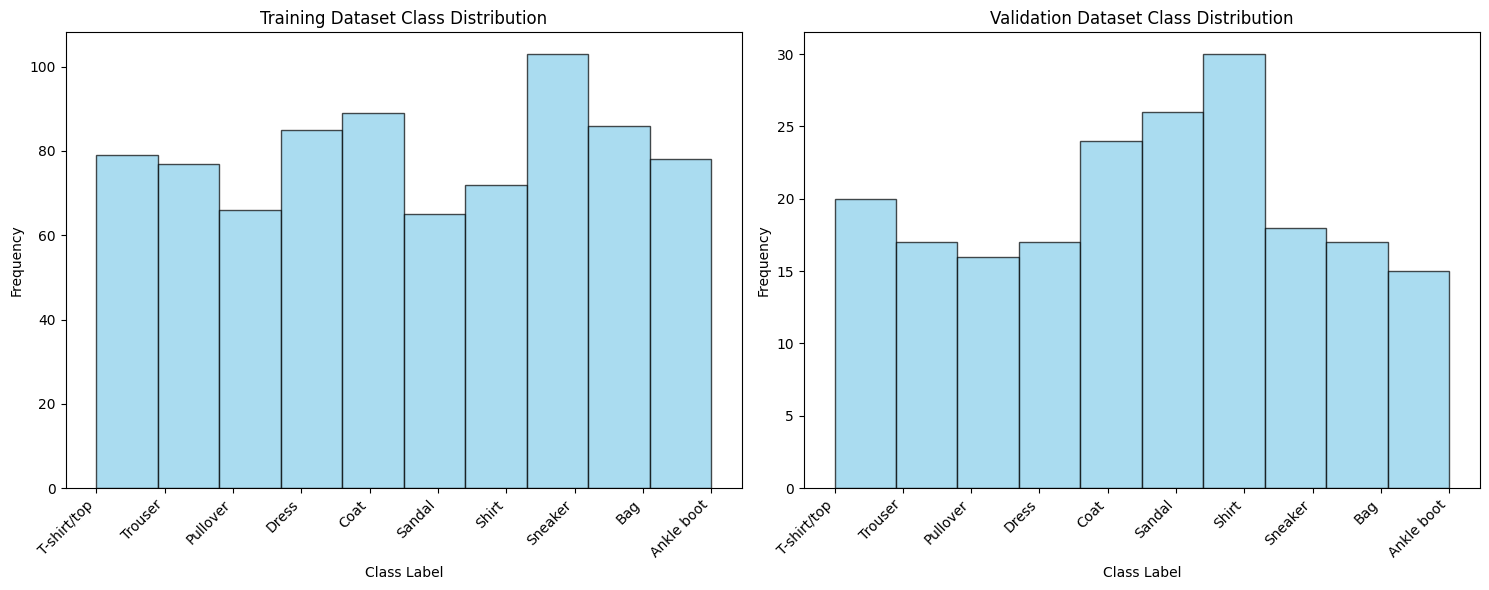

In [5]:
def plot_class_distribution(loader, dataset, title):
    # Initialize empty list to store class labels
    class_labels = []

    # Iterate over the loader to extract class labels
    for _, _, _, anchor_label, _, _ in loader:
        class_labels.extend(anchor_label.numpy().tolist())

    # Plot histogram of class distribution
    plt.hist(class_labels, bins=len(dataset.classes), color='skyblue', edgecolor='black', alpha=0.7)
    plt.title(title)
    plt.xlabel('Class Label')
    plt.ylabel('Frequency')
    plt.xticks(range(len(dataset.classes)), dataset.classes, rotation=45, ha='right')

# Create subplots for side-by-side plotting
plt.figure(figsize=(15, 6))

# Plot training dataset distribution
plt.subplot(1, 2, 1)
plot_class_distribution(train_loader_triplet, full_dataset, 'Training Dataset Class Distribution')

# Plot validation dataset distribution
plt.subplot(1, 2, 2)
plot_class_distribution(val_loader_triplet, full_dataset, 'Validation Dataset Class Distribution')

# Adjust layout and display plot
plt.tight_layout()
plt.show()

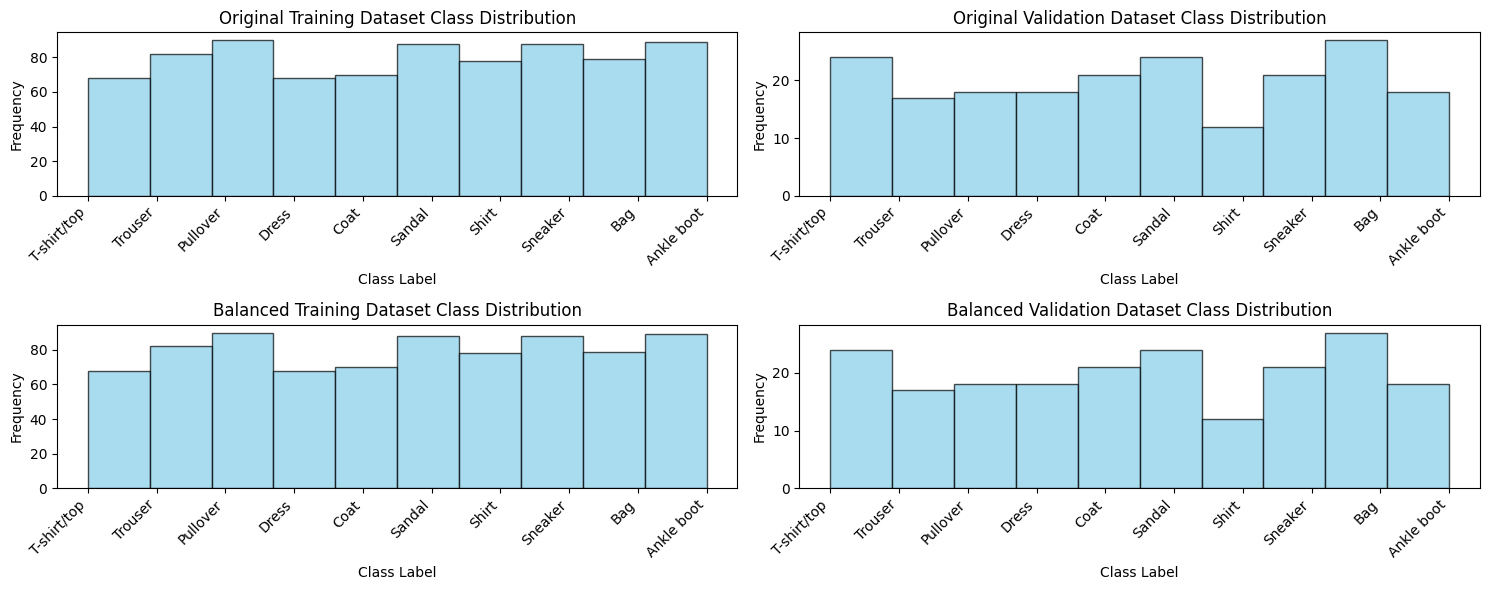

In [7]:
def plot_class_distribution(loader, dataset, title):
    # Initialize empty list to store class labels
    class_labels = []

    # Iterate over the loader to extract class labels
    for _, _, _, anchor_label, _, _ in loader:
        class_labels.extend(anchor_label.numpy().tolist())

    # Plot histogram of class distribution
    plt.hist(class_labels, bins=len(dataset.classes), color='skyblue', edgecolor='black', alpha=0.7)
    plt.title(title)
    plt.xlabel('Class Label')
    plt.ylabel('Frequency')
    plt.xticks(range(len(dataset.classes)), dataset.classes, rotation=45, ha='right')

# Create subplots for side-by-side plotting
plt.figure(figsize=(15, 6))

# Plot original training dataset distribution
plt.subplot(2, 2, 1)
plot_class_distribution(DataLoader(train_subset, batch_size=64), full_dataset, 'Original Training Dataset Class Distribution')

# Plot original validation dataset distribution
plt.subplot(2, 2, 2)
plot_class_distribution(DataLoader(val_subset, batch_size=64), full_dataset, 'Original Validation Dataset Class Distribution')

# Plot balanced training dataset distribution
plt.subplot(2, 2, 3)
plot_class_distribution(train_loader_triplet, full_dataset, 'Balanced Training Dataset Class Distribution')

# Plot balanced validation dataset distribution
plt.subplot(2, 2, 4)
plot_class_distribution(val_loader_triplet, full_dataset, 'Balanced Validation Dataset Class Distribution')

# Adjust layout and display plot
plt.tight_layout()
plt.show()

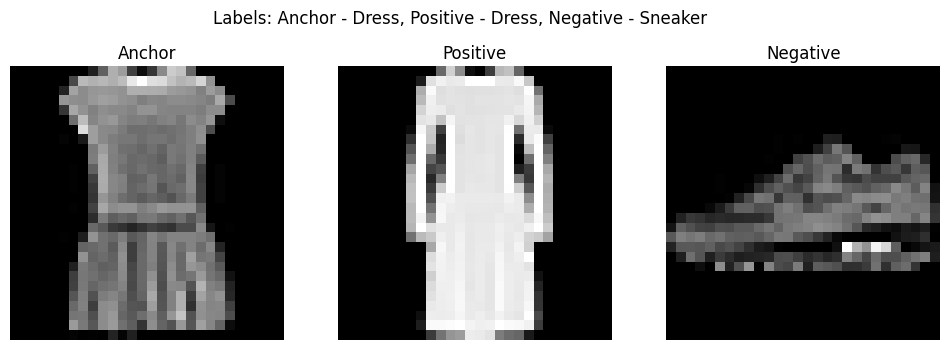

In [8]:
# Define the label names for FashionMNIST
label_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Create an instance of TripletMNIST
triplet_dataset = TripletMNIST(full_dataset)

# Choose an index to get an example
index = 3

# Get the anchor, positive, and negative samples along with their labels
anchor_img, positive_img, negative_img, anchor_label, positive_label, negative_label = triplet_dataset[index]

# Map label indices to label names
anchor_label_name = label_names[anchor_label]
positive_label_name = label_names[positive_label]
negative_label_name = label_names[negative_label]

# Display the anchor, positive, and negative samples
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
axes[0].imshow(anchor_img.squeeze(), cmap='gray')
axes[0].set_title('Anchor')
axes[0].axis('off')
axes[1].imshow(positive_img.squeeze(), cmap='gray')
axes[1].set_title('Positive')
axes[1].axis('off')
axes[2].imshow(negative_img.squeeze(), cmap='gray')
axes[2].set_title('Negative')
axes[2].axis('off')

# Add suptitle with the actual label names
fig.suptitle(f'Labels: Anchor - {anchor_label_name}, Positive - {positive_label_name}, Negative - {negative_label_name}')
plt.show()


Anchor images shape: torch.Size([64, 1, 28, 28])
Positive images shape: torch.Size([64, 1, 28, 28])
Negative images shape: torch.Size([64, 1, 28, 28])


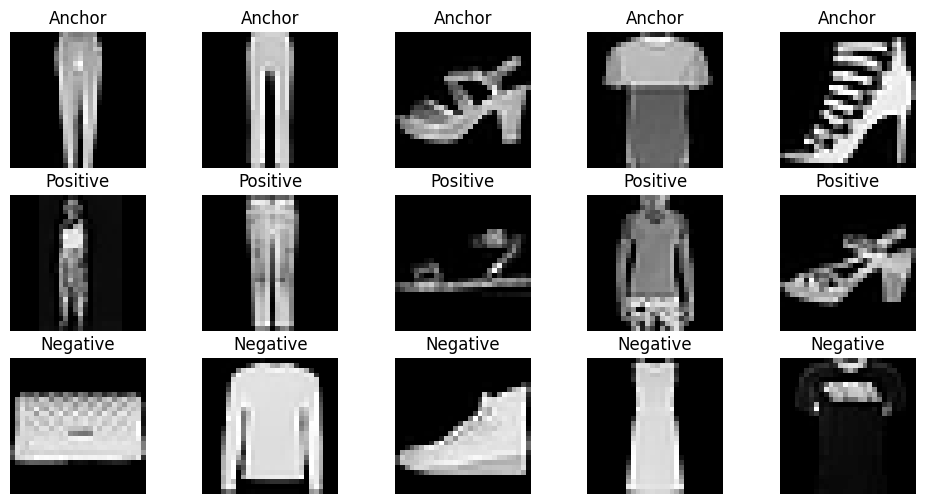

In [9]:
# Define the label names for FashionMNIST
label_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Inspect the structure of a batch
for batch in train_loader_triplet:
    # Extract images and labels from the batch
    anchor_images = batch[0]
    positive_images = batch[1]
    negative_images = batch[2]

    # Print the shape of the images tensor
    print("Anchor images shape:", anchor_images.shape)
    print("Positive images shape:", positive_images.shape)
    print("Negative images shape:", negative_images.shape)

    # Plot several images in subplots
    num_images = 5  # Number of images to plot
    fig, axes = plt.subplots(3, num_images, figsize=(12, 6))

    # Plot each image with its corresponding label name as the title
    for i in range(num_images):
        # Anchor image
        ax = axes[0, i]
        ax.imshow(anchor_images[i].permute(1, 2, 0).squeeze(), cmap='gray')
        ax.axis('off')  # Hide axis
        ax.set_title("Anchor")

        # Positive image
        ax = axes[1, i]
        ax.imshow(positive_images[i].permute(1, 2, 0).squeeze(), cmap='gray')
        ax.axis('off')  # Hide axis
        ax.set_title("Positive")

        # Negative image
        ax = axes[2, i]
        ax.imshow(negative_images[i].permute(1, 2, 0).squeeze(), cmap='gray')
        ax.axis('off')  # Hide axis
        ax.set_title("Negative")

    plt.show()
    break  # Only print the first batch


In [10]:
# Inspect the structure of a batch
for batch in train_loader_triplet:
    print("Batch structure:", len(batch))
    break  # Only inspect the first batch


Batch structure: 6


In [6]:
# change the learning rate to see what the errors are
# try different loss functions with distance metrics

# Set the hyperparameters 
num_epochs = 10
best_val_loss = np.inf
patience = 2

# Initialize the loss and accuracy captures
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    # Train the model
    matched_model.train()
    total_train_loss = 0.0
    correct_train = 0
    total_train = 0
    for batch in train_loader_triplet:
        optimizer.zero_grad()
        anchor_imgs, positive_imgs, negative_imgs = batch[:3]
        output1, output2, output3 = matched_model(anchor_imgs, positive_imgs, negative_imgs)
        loss = criterion(output1, output2, output3)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()
        
        # Compute training accuracy
        _, predicted = torch.max(output1, 1)  # Assuming output1 is the output of the model
        total_train += anchor_imgs.size(0)
        correct_train += (predicted == batch[3]).sum().item()  # Assuming true labels are at index 3 in the batch
    
    avg_train_loss = total_train_loss / len(train_loader_triplet)
    train_losses.append(avg_train_loss)
    train_accuracy = correct_train / total_train
    train_accuracies.append(train_accuracy)

    # Validation loop
    matched_model.eval()
    total_val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for batch in val_loader_triplet:
            anchor_imgs, positive_imgs, negative_imgs = batch[:3]
            output1, output2, output3 = matched_model(anchor_imgs, positive_imgs, negative_imgs)
            loss = criterion(output1, output2, output3)
            total_val_loss += loss.item()
            
            # Compute validation accuracy
            _, predicted = torch.max(output1, 1)  # Assuming output1 is the output of the model
            total_val += anchor_imgs.size(0)
            correct_val += (predicted == batch[3]).sum().item()  # Assuming true labels are at index 3 in the batch
    
    avg_val_loss = total_val_loss / len(val_loader_triplet)
    val_losses.append(avg_val_loss)
    val_accuracy = correct_val / total_val
    val_accuracies.append(val_accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {round(avg_train_loss,4)}, Validation Loss: {round(avg_val_loss,4)}, Training Accuracy: {round(train_accuracy,4)}, Validation Accuracy: {round(val_accuracy,4)}")

    # Check for early stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve == patience:
            print(f"Validation loss did not improve for {patience} epochs. Early stopping...")
            break
            
print('Finished Training')

Epoch [1/10], Training Loss: 0.5438, Validation Loss: 0.4258, Training Accuracy: 0.0, Validation Accuracy: 0.005
Epoch [2/10], Training Loss: 0.349, Validation Loss: 0.3254, Training Accuracy: 0.0, Validation Accuracy: 0.0
Epoch [3/10], Training Loss: 0.2564, Validation Loss: 0.2685, Training Accuracy: 0.0, Validation Accuracy: 0.0
Epoch [4/10], Training Loss: 0.2451, Validation Loss: 0.2436, Training Accuracy: 0.0, Validation Accuracy: 0.0
Epoch [5/10], Training Loss: 0.2134, Validation Loss: 0.2422, Training Accuracy: 0.0, Validation Accuracy: 0.0
Epoch [6/10], Training Loss: 0.2421, Validation Loss: 0.278, Training Accuracy: 0.0, Validation Accuracy: 0.0
Epoch [7/10], Training Loss: 0.2465, Validation Loss: 0.2562, Training Accuracy: 0.0, Validation Accuracy: 0.0
Validation loss did not improve for 2 epochs. Early stopping...
Finished Training


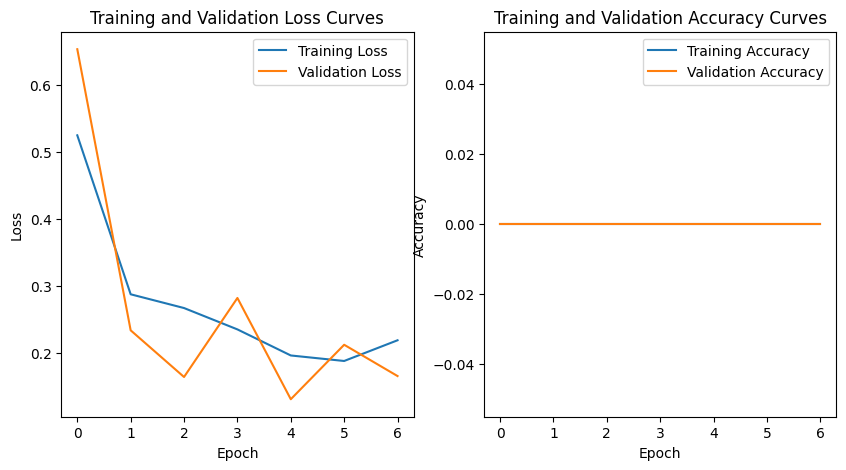

In [12]:
# Plot the loss and accuracy curves
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curves')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy Curves')
plt.legend()
plt.show()

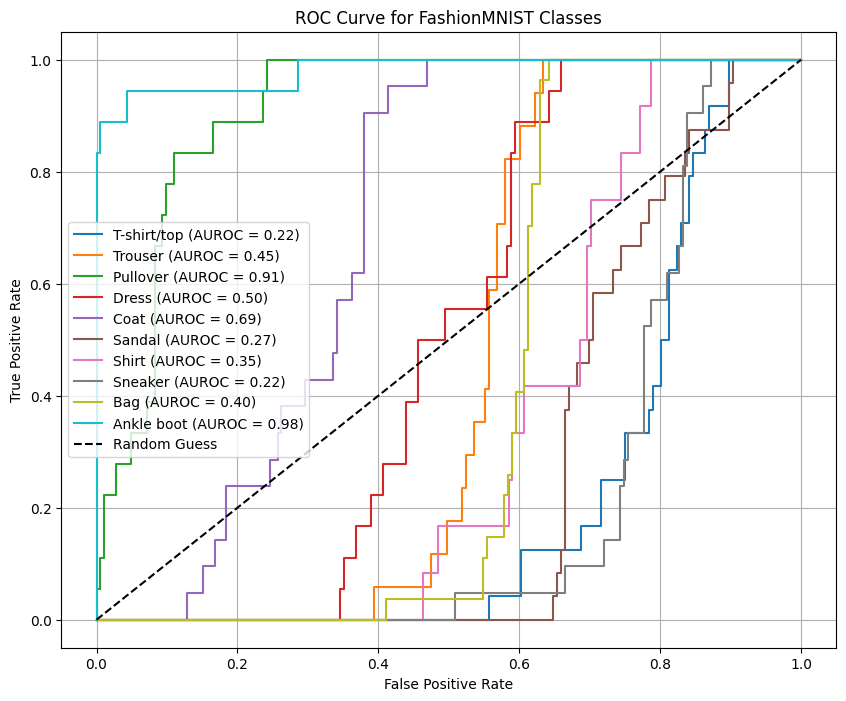

In [13]:
# Define label names for FashionMNIST
label_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Initialize lists to store true labels and predicted scores
true_labels = []
predicted_scores = []

# Iterate through the data loader to get predictions
with torch.no_grad():
    for batch in val_loader_triplet:
        anchor_imgs, positive_imgs, negative_imgs, anchor_labels, _, _ = batch
        output = matched_model.forward_once(anchor_imgs)
        true_labels.extend(anchor_labels.numpy())
        predicted_scores.extend(output.numpy())

# Convert lists to numpy arrays
true_labels = np.array(true_labels)
predicted_scores = np.array(predicted_scores)

# Calculate the number of classes
num_classes = len(np.unique(true_labels))

# Plot ROC curves for each class
plt.figure(figsize=(10, 8))
for class_label in range(num_classes):
    # Extract true labels and predicted scores for the current class
    class_true_labels = (true_labels == class_label).astype(int)
    class_predicted_scores = predicted_scores[:, class_label]
    
    # Calculate ROC curve
    fpr, tpr, _ = roc_curve(class_true_labels, class_predicted_scores)
    
    # Calculate AUROC score
    auroc = roc_auc_score(class_true_labels, class_predicted_scores)
    
    # Plot ROC curve with label names
    plt.plot(fpr, tpr, label=f'{label_names[class_label]} (AUROC = {auroc:.2f})')

# Plot random guess line
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')

# Set plot labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for FashionMNIST Classes')
plt.legend()
plt.grid(True)
plt.show()

In [14]:
# Evaluate the model on the validation set
matched_model.eval()

# Initialize empty lists to store true and predicted labels
true_labels = []
predicted_labels = []

# Iterate over the validation dataset
with torch.no_grad():
    for batch in val_loader_triplet:
        # Unpack the batch
        anchor_imgs, positive_imgs, negative_imgs = batch[:3]  # Adjust unpacking based on batch structure
        
        # Forward pass through the model
        outputs = matched_model(anchor_imgs, positive_imgs, negative_imgs) 
        
        # Extract the predicted labels
        _, predicted = torch.max(outputs[0], 1)  # Assuming outputs is a tuple of output tensors
        print(predicted)
        
        # Append true labels and predicted labels
        true_labels.append(batch[3].numpy())  # Assuming true labels are at index 3 in the batch
        predicted_labels.append(predicted.cpu().numpy())

# # Concatenate true labels and predicted labels across all batches
# true_labels = np.concatenate(true_labels)
# predicted_labels = np.concatenate(predicted_labels)


# # Define label names for FashionMNIST
# label_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
#                'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# # Function to compute and visualize confusion matrix
# def plot_confusion_matrix(true_labels, predicted_labels, label_names):
#     # Compute confusion matrix
#     cm = confusion_matrix(true_labels, predicted_labels)
#     # Plot confusion matrix as heatmap
#     plt.figure(figsize=(10, 8))
#     sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=label_names, yticklabels=label_names)
#     plt.xlabel('Predicted Labels')
#     plt.ylabel('True Labels')
#     plt.title('Confusion Matrix')
#     plt.show()

# # Plot confusion matrix
# plot_confusion_matrix(true_labels, predicted_labels, label_names)


tensor([ 59,  23,  23,  23,  23,  23,  66,  66,  23,  59,  23,  23,  23,  23,
         23,  23,  23, 106,  72,  23,  72,  56,  66,  56,  23, 123,  23,  23,
         23,  23,  72,  23,  23,  23,  59,  23,  23,  23,  72,  23,  23,  23,
         72,  72,  23,  70,  23,  72,  23,  59,  23,  23,  23,  66,  23,  23,
         23,  56,  23,  23,  23,  23,  23,  59])
tensor([ 83,  23,  23,  23,  23,  23,  23,  23,  23,  56,  23,  56,  66,  23,
         72,  23,  72,  59, 101,  23,  23,  66,  23,  23,  56,  66,  72,  23,
         66,  70,  59,  66,  59,  66,  23,  72,  66,  56, 101,  23,  72, 127,
         59,  23,  56,  23,  23,  23,  59,  23,  59,  23,  23,  66,  59,  72,
         59,  23, 106,  23, 127,  23,  23,  72])
tensor([ 23,  72,  23,  23,  70,  59,  56,  23,  72,  23,  72,  56,  70,  56,
         72,  59,  23,  23,  23,  23,  23,  59,  23,  70,  72,  23,  59,  23,
         66,  23,  72,  23,  23,  23,  23,  23,  23,  23,  23,  56,  59,  66,
         59,  59,  23,  23,  66,  23,  66,  

/Users/wren/Documents/tcheandjieulabnotebook/myenv/lib/python3.9/site-packages/threadpoolctl.py:1186: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


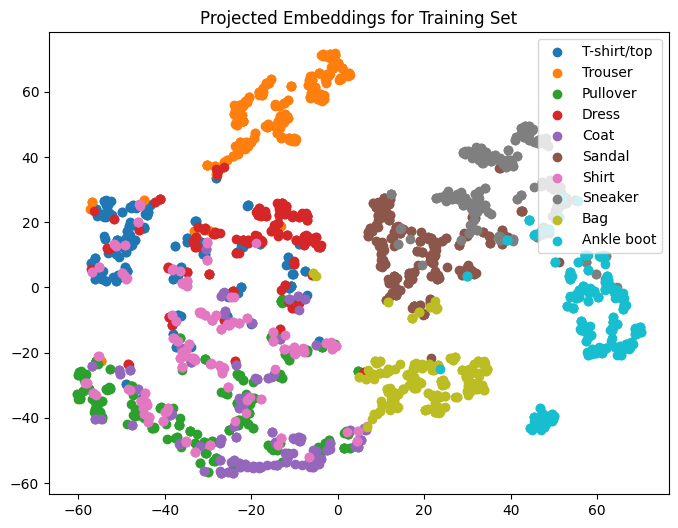

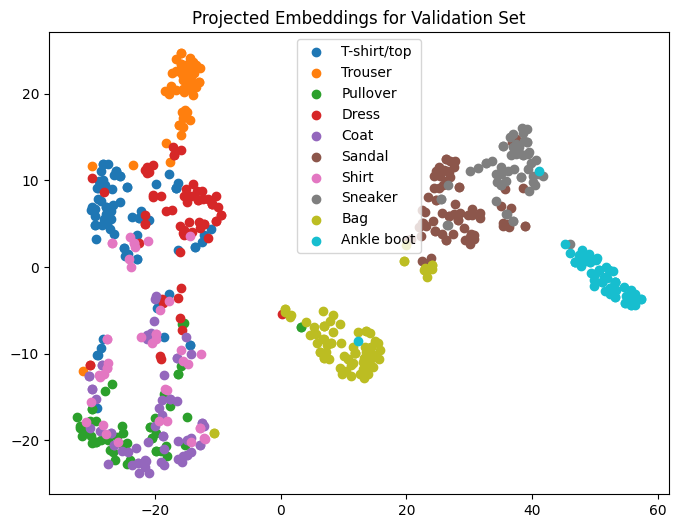

In [15]:
# Define label names for FashionMNIST
label_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
# Define a function to extract and visualize embeddings
def visualize_embeddings(loader, title):
    embeddings = []
    labels = []
    with torch.no_grad():
        for batch in loader:
            anchor_imgs, positive_imgs, negative_imgs = batch[:3]
            output1, output2, output3 = matched_model(anchor_imgs, positive_imgs, negative_imgs)
            embeddings.extend([output1.numpy(), output2.numpy(), output3.numpy()])
            labels.extend([batch[3].numpy(), batch[4].numpy(), batch[5].numpy()])  # Assuming the anchor, positive, and negative labels are at index 3, 4, and 5

    # Concatenate embeddings and labels
    embeddings = np.concatenate(embeddings)
    labels = np.concatenate(labels)

    # Apply t-SNE for dimensionality reduction
    tsne = TSNE(n_components=2, random_state=42)
    embeddings_2d = tsne.fit_transform(embeddings)
    
    # Visualize projected embeddings
    plt.figure(figsize=(8,6))
    for label_idx, label_name in enumerate(label_names):
        plt.scatter(embeddings_2d[labels == label_idx, 0], embeddings_2d[labels == label_idx, 1], label=label_name)
    plt.title(title)
    plt.legend()
    plt.show()

# Visualize embeddings for training set
visualize_embeddings(train_loader_triplet, 'Projected Embeddings for Training Set')

# Visualize embeddings for validation set
visualize_embeddings(val_loader_triplet, 'Projected Embeddings for Validation Set')

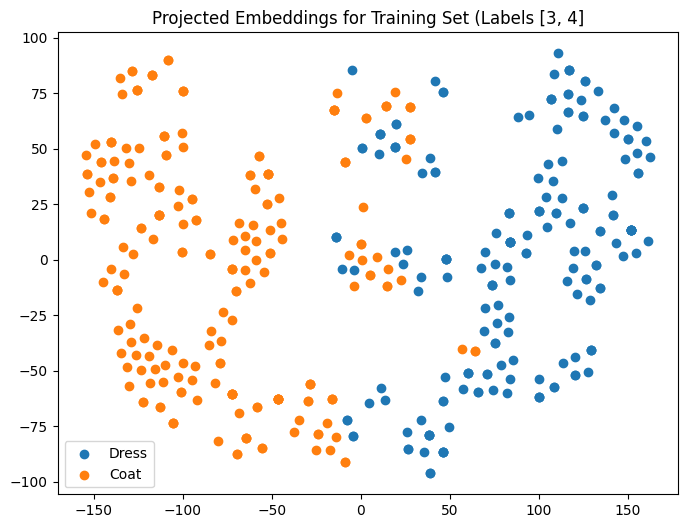

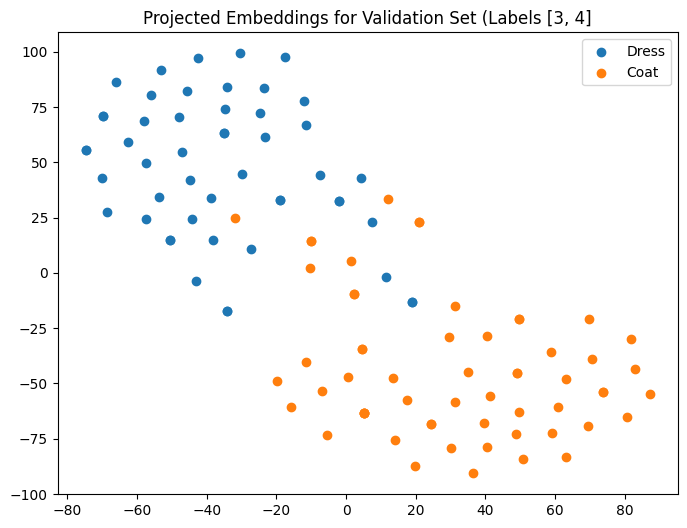

In [16]:
# Select the list of clusters to visualize
clsuters_to_visualize = [3,4]

# Define a function to extract and visualize embeddings
def visualize_embeddings(loader, title, labels_to_project):
    embeddings = []
    labels = []
    with torch.no_grad():
        for batch in loader:
            anchor_imgs, positive_imgs, negative_imgs = batch[:3]
            output1, output2, output3 = matched_model(anchor_imgs, positive_imgs, negative_imgs)
            embeddings.extend([output1.numpy(), output2.numpy(), output3.numpy()])
            labels.extend([batch[3].numpy(), batch[4].numpy(), batch[5].numpy()])  # Assuming the anchor, positive, and negative labels are at index 3, 4, and 5

    # Concatenate embeddings and labels
    embeddings = np.concatenate(embeddings)
    labels = np.concatenate(labels)

    # Filter embeddings and labels for the specified labels to project
    filter_mask = np.isin(labels, labels_to_project)
    filtered_embeddings = embeddings[filter_mask]
    filtered_labels = labels[filter_mask]

    # Apply t-SNE for dimensionality reduction
    tsne = TSNE(n_components=2, random_state=42)
    embeddings_2d = tsne.fit_transform(filtered_embeddings)
    
    # Visualize projected embeddings
    plt.figure(figsize=(8,6))
    for label_idx, label_name in enumerate(label_names):
        if label_idx in labels_to_project:
            plt.scatter(embeddings_2d[filtered_labels == label_idx, 0], embeddings_2d[filtered_labels == label_idx, 1], label=label_name)
    plt.title(title)
    plt.legend()
    plt.show()

# Visualize embeddings for labels 3 and 4 in the training set
visualize_embeddings(train_loader_triplet, 'Projected Embeddings for Training Set (Labels {0}'.format(clsuters_to_visualize), clsuters_to_visualize)

# Visualize embeddings for labels 3 and 4 in the validation set
visualize_embeddings(val_loader_triplet, 'Projected Embeddings for Validation Set (Labels {0}'.format(clsuters_to_visualize), clsuters_to_visualize)


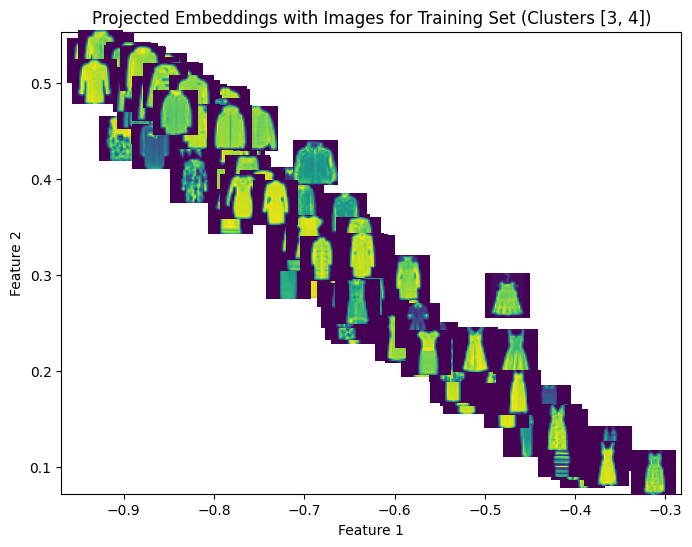

In [17]:
# Select the clusters to visualize
clusters_to_visualize = [3,4]

# Define a function to extract and visualize embeddings
def visualize_embeddings_with_images(loader, model, title, labels_to_display):
    plt.figure(figsize=(8,6))
    plt.title(title)

    # Keep track of the number of embeddings displayed
    num_embeddings_displayed = 0

    with torch.no_grad():
        for batch in loader:
            anchor_imgs, _, _ = batch[:3]  # Only need anchor images
            outputs = model.forward_once(anchor_imgs)
            for embedding, label, image in zip(outputs, batch[3], anchor_imgs):
                # Check if the label matches the ones we want to display
                if label.item() in labels_to_display:
                    # Plot the embedding
                    plt.scatter(embedding[0], embedding[1], color='blue', label=f'Label: {label.item()}')

                    # Convert PyTorch tensor to NumPy array
                    image_np = image.squeeze().cpu().numpy()
                    # Resize image using OpenCV
                    resized_image = cv2.resize(image_np, (32, 32))  # Resize to (32, 32)

                    # Create an AnnotationBbox with the image
                    imagebox = OffsetImage(resized_image, zoom=1)
                    ab = AnnotationBbox(imagebox, (embedding[0], embedding[1]), frameon=False)
                    plt.gca().add_artist(ab)

                    num_embeddings_displayed += 1

            # Break if displayed enough embeddings
            if num_embeddings_displayed == len(labels_to_display):
                break

    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    # plt.legend()
    plt.show()

# Assuming matched_model is the trained Matched network model
# Assuming train_loader_triplet is the DataLoader containing the training data
visualize_embeddings_with_images(train_loader_triplet, matched_model, 
                                 'Projected Embeddings with Images for Training Set (Clusters {0})'.format(clusters_to_visualize),
                                  clusters_to_visualize)



/Users/wren/Documents/tcheandjieulabnotebook/myenv/lib/python3.9/site-packages/torch/nn/modules/module.py:1352: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


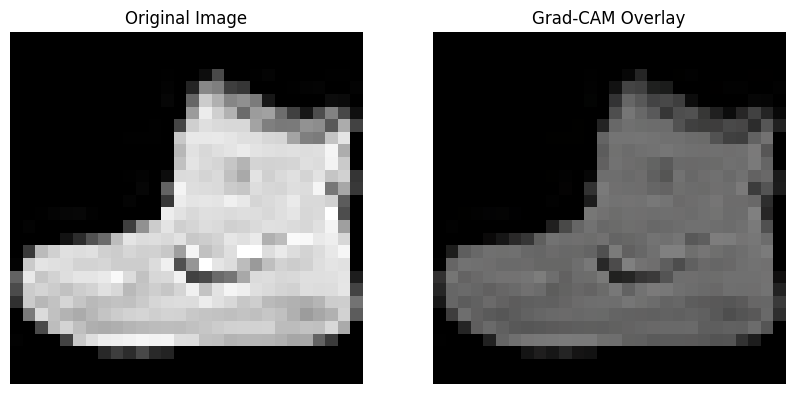

In [18]:
# Define a class to do the gradcam
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.model.eval()
        self.feature_grad = None
        self.hook = self.register_hooks()

    def register_hooks(self):
        def forward_hook(module, input, output):
            output.requires_grad_(True)

        def backward_hook(module, grad_in, grad_out):
            self.feature_grad = grad_out[0]

        hook = self.target_layer.register_forward_hook(forward_hook)
        _ = self.target_layer.register_backward_hook(backward_hook)
        return hook

    def generate_grad_cam(self, input_image1, input_image2, input_image3, target_class=None):
        self.model.zero_grad()
        output1, _, _ = self.model(input_image1, input_image2, input_image3)  # Forward pass through the Matched network
        if target_class is None:
            target_class = torch.argmax(output1, dim=1)

        # Compute gradients for the target class
        one_hot_output = torch.zeros_like(output1)
        one_hot_output[torch.arange(len(output1)), target_class] = 1
        output1.backward(gradient=one_hot_output, retain_graph=True)

        # Compute Grad-CAM
        weights = torch.mean(self.feature_grad, dim=(2, 3), keepdim=True)
        grad_cam = torch.mean(weights * self.feature_grad, dim=1).squeeze()
        grad_cam = F.relu(grad_cam)

        # Normalize Grad-CAM
        grad_cam = (grad_cam - torch.min(grad_cam)) / (torch.max(grad_cam) - torch.min(grad_cam) + 1e-8)

        return grad_cam.detach().cpu().numpy()

    def remove_hooks(self):
        self.hook.remove()

# Define a function to overlay the grad cam on the original image
def overlay_grad_cam(input_image, grad_cam_map, alpha=0.5):
    # Convert the input image to a numpy array and scale it to the range [0, 255]
    input_image_np = (input_image.permute(1, 2, 0).cpu().numpy() * 255).astype(np.uint8)
    
    # Resize the Grad-CAM map to match the input image dimensions
    grad_cam_map_resized = cv2.resize(grad_cam_map, (input_image_np.shape[1], input_image_np.shape[0]))
    
    # Apply the colormap to the resized Grad-CAM map
    heatmap = cv2.applyColorMap(np.uint8(255 * grad_cam_map_resized), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    
    # Convert the input image to a three-channel image
    input_image_resized = cv2.cvtColor(input_image_np, cv2.COLOR_GRAY2RGB)
    
    # Blend the resized input image and the heatmap using alpha blending
    output_image = cv2.addWeighted(input_image_resized, alpha, heatmap, 1 - alpha, 0, dtype=cv2.CV_8U)
    
    return input_image_resized, output_image

# Assuming model is your MatchedNetwork model
grad_cam = GradCAM(matched_model, matched_model.conv_layers[-3])  # Assuming last convolutional layer is target layer

# Assuming dataset is your TripletMNIST dataset
for anchor_img, positive_img, negative_img, anchor_label, _, _ in triplet_dataset:

    # Pass the anchor, positive, and negative images to the GradCAM object to generate Grad-CAM
    grad_cam_map = grad_cam.generate_grad_cam(anchor_img.unsqueeze(0), positive_img.unsqueeze(0), negative_img.unsqueeze(0), target_class=anchor_label)
    
    # Overlay Grad-CAM on input image and display
    input_image, output_image = overlay_grad_cam(anchor_img, grad_cam_map)
    
    # Plot original image and overlay image side by side
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(input_image)
    plt.title('Original Image')
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(output_image)
    plt.title('Grad-CAM Overlay')
    plt.axis('off')
    
    plt.show()
    break  # Break after visualizing the first image


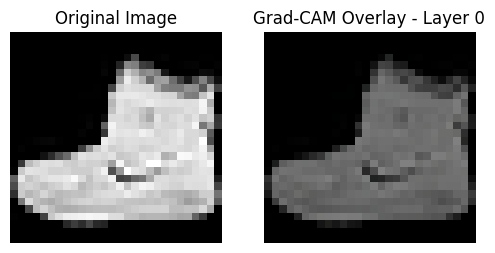

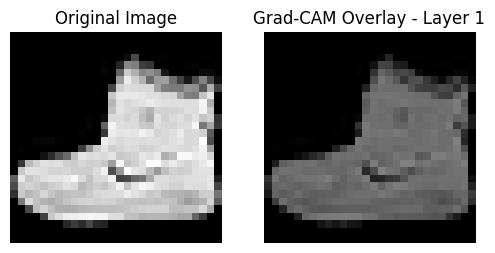

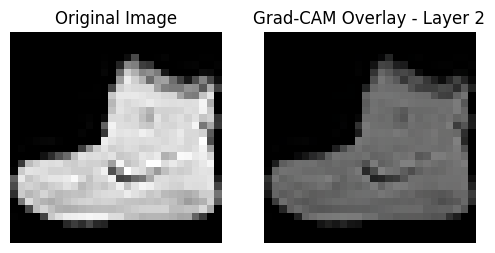

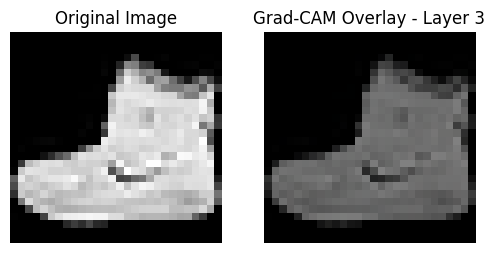

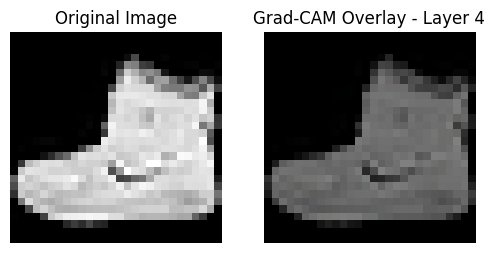

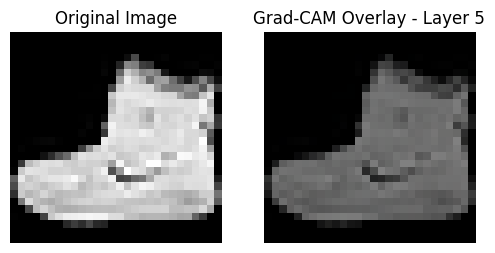

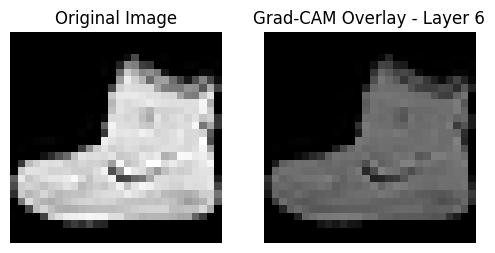

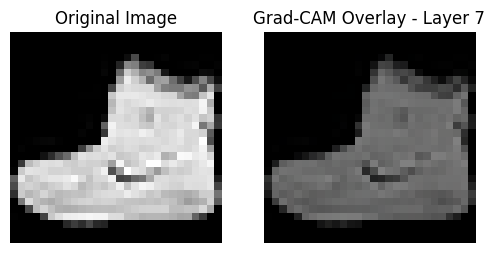

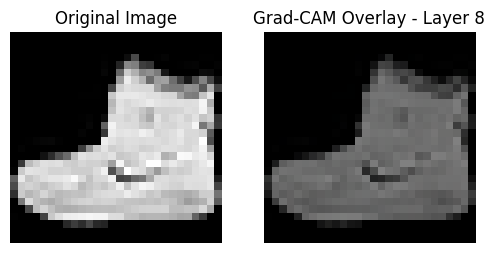

In [19]:
# Define a function to overlay the grad cam on the original image
def overlay_grad_cam(input_image, grad_cam_map, alpha=0.5):
    # Convert the input image to a numpy array and scale it to the range [0, 255]
    input_image_np = (input_image.permute(1, 2, 0).cpu().numpy() * 255).astype(np.uint8)
    
    # Resize the Grad-CAM map to match the input image dimensions
    grad_cam_map_resized = cv2.resize(grad_cam_map, (input_image_np.shape[1], input_image_np.shape[0]))
    
    # Convert the input image to a three-channel image
    input_image_resized = cv2.cvtColor(input_image_np, cv2.COLOR_GRAY2RGB)
    
    # Apply colormap to the Grad-CAM map
    heatmap = cv2.applyColorMap(np.uint8(255 * grad_cam_map_resized), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    
    # Blend the input image and the heatmap using alpha blending
    output_image = cv2.addWeighted(input_image_resized, 1-alpha, heatmap, alpha, 0, dtype=cv2.CV_8U)
    
    return output_image

# Assuming model is your MatchedNetwork model
grad_cam = GradCAM(matched_model, matched_model.conv_layers[-1])  # Start from the last convolutional layer

# Iterate over each convolutional layer in the model
for layer_idx, layer in enumerate(matched_model.conv_layers):
    # Update the target layer for Grad-CAM
    grad_cam.target_layer = layer
    
    # Assuming dataset is your TripletMNIST dataset
    for anchor_img, positive_img, negative_img, anchor_label, _, _ in triplet_dataset:
        # Pass the anchor, positive, and negative images to the GradCAM object to generate Grad-CAM
        grad_cam_map = grad_cam.generate_grad_cam(anchor_img.unsqueeze(0), positive_img.unsqueeze(0), negative_img.unsqueeze(0), target_class=anchor_label)
        
        # Overlay Grad-CAM on input image and display
        output_image = overlay_grad_cam(anchor_img, grad_cam_map)
        
        # Plot original image and overlay image side by side
        plt.figure(figsize=(6,3))
        plt.subplot(1, 2, 1)
        plt.imshow(anchor_img.squeeze(), cmap='gray')
        plt.title('Original Image')
        plt.axis('off')
        
        plt.subplot(1, 2, 2)
        plt.imshow(output_image)
        plt.title(f'Grad-CAM Overlay - Layer {layer_idx}')
        plt.axis('off')
        
        plt.show()
        
        break  # Break after visualizing the Grad-CAM for the first image
        
    # break  # Break after visualizing Grad-CAM for the first layer


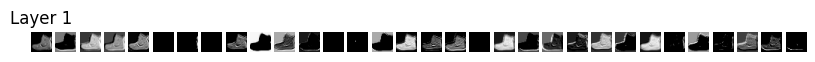

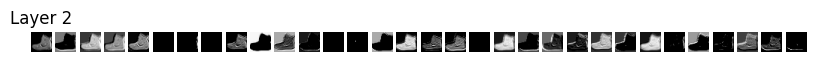

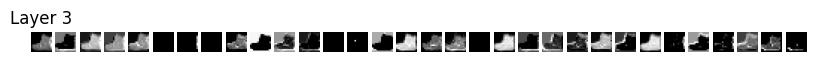

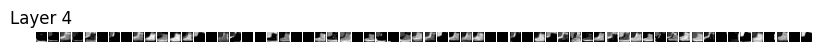

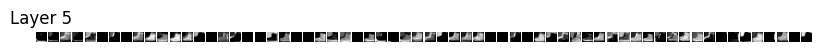

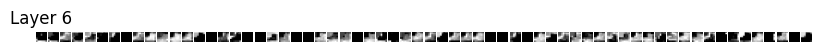

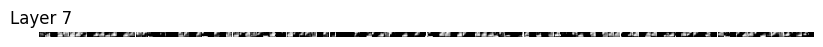

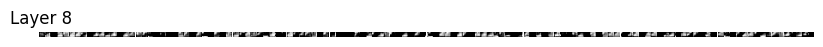

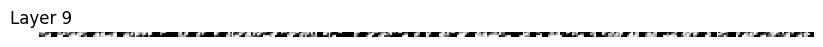

In [20]:
# Function to extract feature maps from a given layer
def get_feature_maps(model, input_image):
    feature_maps = []
    x = input_image.unsqueeze(0)
    for layer in model.conv_layers:
        x = layer(x)
        feature_maps.append(x)
    return feature_maps

# Assuming model is your MatchedNetwork model
# Assuming dataset is your TripletMNIST dataset
for anchor_img, positive_img, negative_img, anchor_label, _, _ in triplet_dataset:
    # Pass the anchor image through the model
    feature_maps = get_feature_maps(matched_model, anchor_img)

    # Visualize feature maps for each layer
    for i, fmap in enumerate(feature_maps):
        num_features = fmap.size(1)
        num_rows = 1
        num_cols = num_features
        fig, axs = plt.subplots(num_rows, num_cols, figsize=(10, 1))
        for j in range(num_features):
            axs[j].imshow(fmap[0, j].detach().cpu(), cmap='gray')
            axs[j].axis('off')
            if j == 0:
                axs[j].set_title(f'Layer {i+1}')
        plt.show()
    break


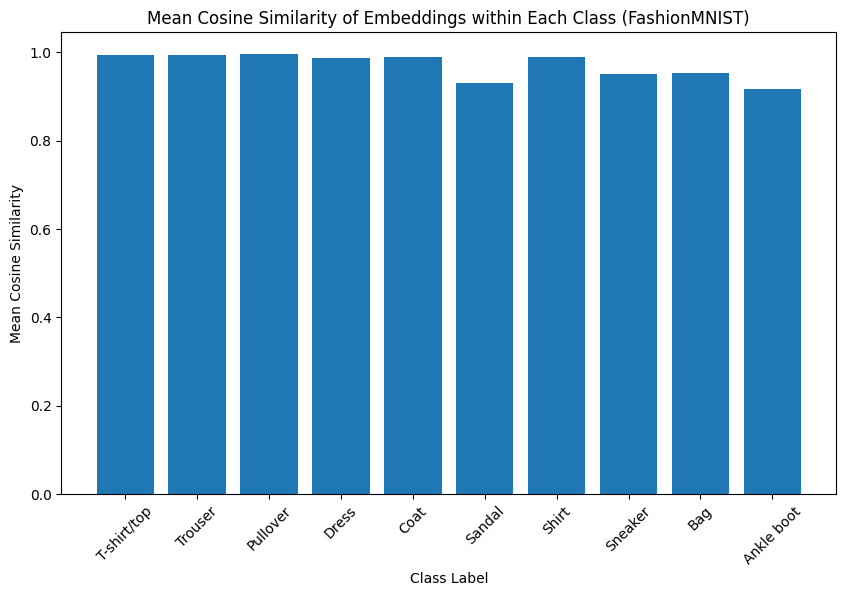

In [21]:
# Obtain embeddings for each image in the dataset
class_embeddings = {i: [] for i in range(10)}  # Dictionary to store embeddings grouped by class
with torch.no_grad():
    for anchor_img, positive_img, negative_img, anchor_label, positive_label, negative_label in triplet_dataset:
        anchor_emb = matched_model.forward_once(anchor_img.unsqueeze(0))
        class_embeddings[anchor_label].append(anchor_emb)

def compute_pairwise_similarities(embeddings):
    similarities = {}
    for class_label, emb_list in embeddings.items():
        emb_array = torch.stack(emb_list)  # Stack tensors along a new dimension
        num_samples = emb_array.shape[0]
        emb_array = emb_array.view(num_samples, -1)  # Flatten the tensor
        sim_matrix = cosine_similarity(emb_array.detach().numpy())  # Compute cosine similarity
        np.fill_diagonal(sim_matrix, 0)
        pairwise_similarities = sim_matrix.sum(axis=1) / (num_samples - 1)
        similarities[class_label] = pairwise_similarities.mean()
    return similarities

# Compute pairwise similarities within each class
similarities = compute_pairwise_similarities(class_embeddings)

# Plot the metric for embedding similarities within classes
plt.figure(figsize=(10, 6))
plt.bar(similarities.keys(), similarities.values())
plt.xlabel('Class Label')
plt.ylabel('Mean Cosine Similarity')
plt.title('Mean Cosine Similarity of Embeddings within Each Class (FashionMNIST)')
plt.xticks(list(range(10)), ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'], rotation=45)
plt.show()

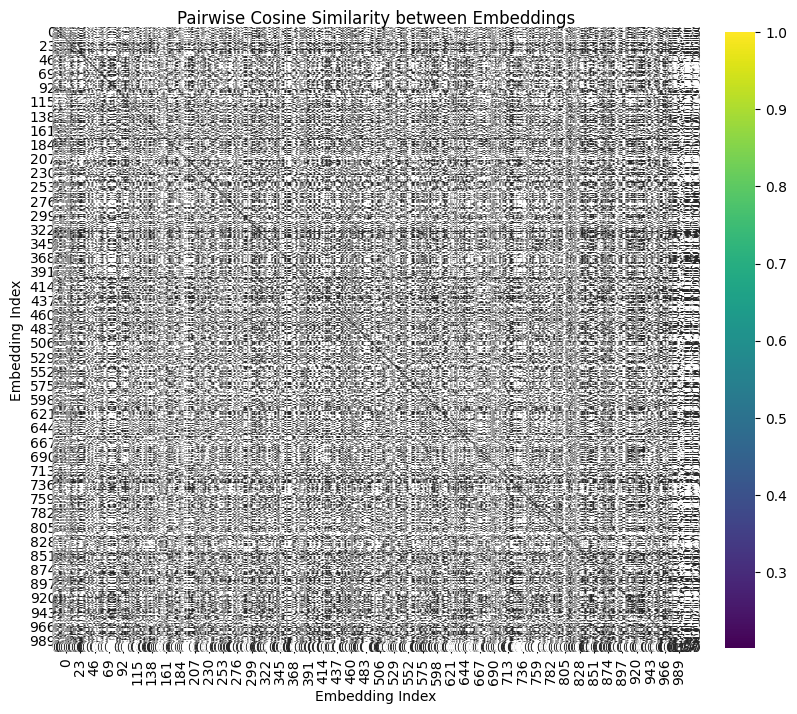

In [7]:
# Initialize a list to store embeddings and labels
all_embeddings = []

# Compute embeddings for all triplets in the dataset
with torch.no_grad():
    for triplet in triplet_dataset:
        anchor_img, positive_img, negative_img, _, _, _ = triplet
        anchor_emb = matched_model.forward_once(anchor_img.unsqueeze(0))
        positive_emb = matched_model.forward_once(positive_img.unsqueeze(0))
        negative_emb = matched_model.forward_once(negative_img.unsqueeze(0))
        triplet_embeddings = torch.cat((anchor_emb, positive_emb, negative_emb), dim=0)
        all_embeddings.append(triplet_embeddings.flatten().numpy())

# Convert the list of embeddings to numpy array
all_embeddings = np.array(all_embeddings)

# Compute pairwise cosine similarity between embeddings
pairwise_similarity = cosine_similarity(all_embeddings)

# Visualize the similarity matrix (optional)
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(pairwise_similarity, cmap='viridis', annot=True, fmt=".2f")
plt.title('Pairwise Cosine Similarity between Embeddings')
plt.xlabel('Embedding Index')
plt.ylabel('Embedding Index')
plt.show()



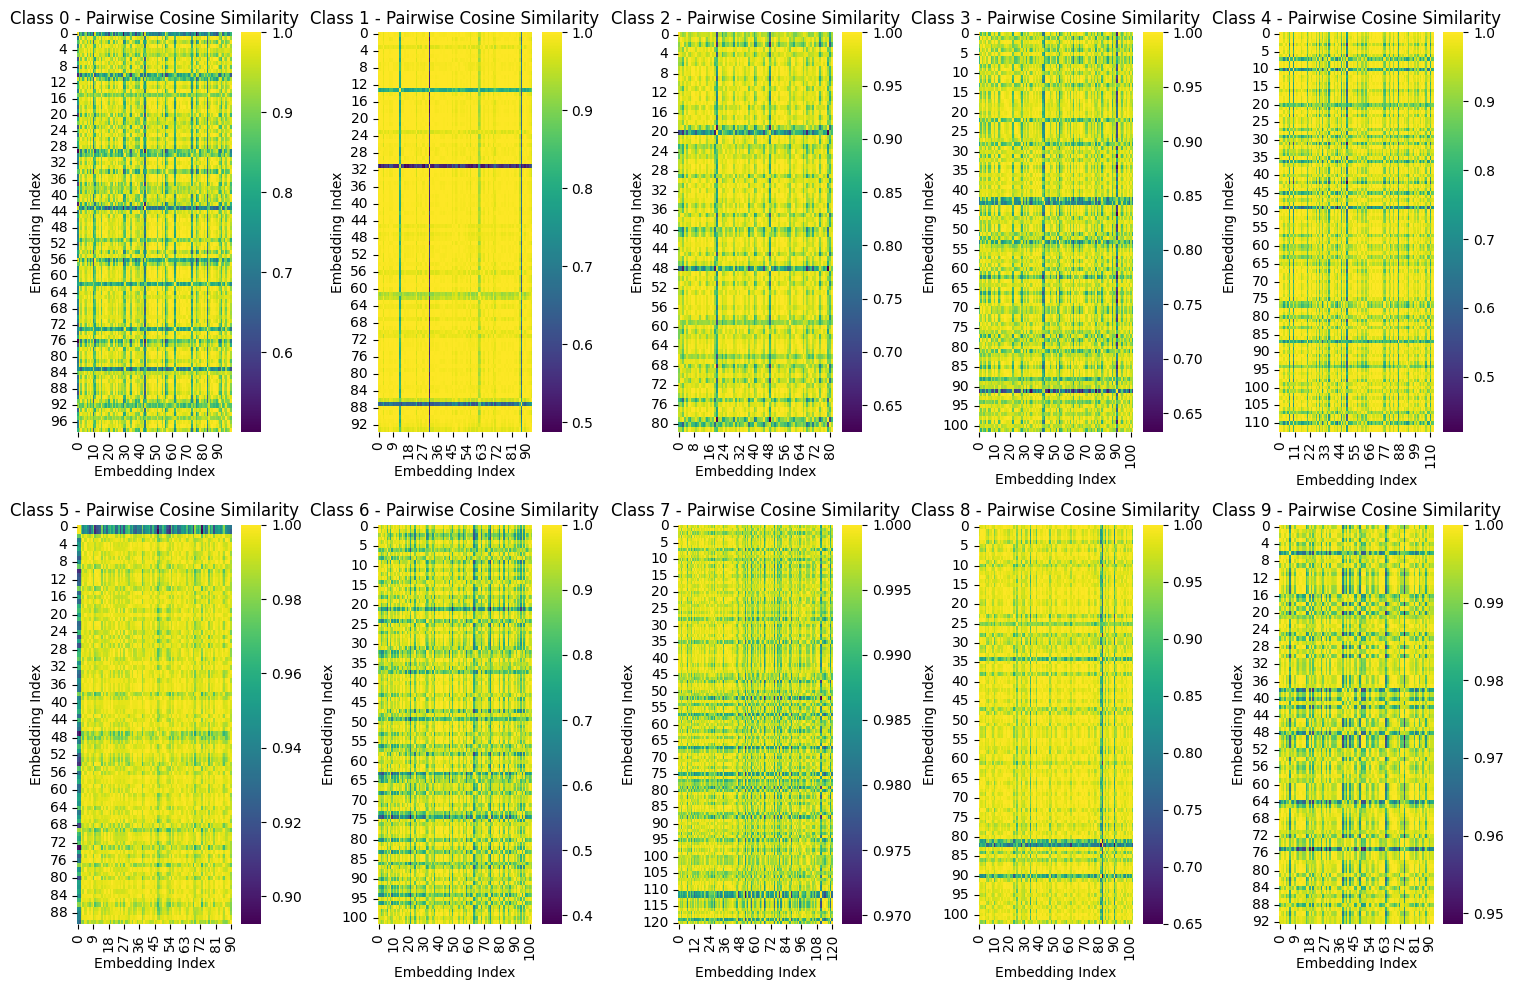

In [10]:
# Initialize a dictionary to store embeddings grouped by class
class_embeddings = {i: [] for i in range(10)}  # Assuming there are 10 classes

# Compute embeddings for all triplets in the dataset
with torch.no_grad():
    for triplet in triplet_dataset:
        anchor_img, positive_img, negative_img, anchor_label, _, _ = triplet
        anchor_emb = matched_model.forward_once(anchor_img.unsqueeze(0))
        # Group the anchor embeddings by class
        class_embeddings[anchor_label].append(anchor_emb.flatten().numpy())

# Convert the embeddings to numpy arrays
for label in class_embeddings:
    class_embeddings[label] = np.array(class_embeddings[label])

# Compute pairwise cosine similarity between embeddings within each class
class_pairwise_similarity = {}
for label in class_embeddings:
    embeddings = class_embeddings[label]
    pairwise_similarity = cosine_similarity(embeddings)
    class_pairwise_similarity[label] = pairwise_similarity

# Visualize the similarity matrix for each class
plt.figure(figsize=(15, 10))
for label in class_pairwise_similarity:
    plt.subplot(2, 5, label+1)  # Assuming there are 10 classes
    sns.heatmap(class_pairwise_similarity[label], cmap='viridis', annot=False, fmt=".2f")
    plt.title(f'Class {label} - Pairwise Cosine Similarity')
    plt.xlabel('Embedding Index')
    plt.ylabel('Embedding Index')
plt.tight_layout()
plt.show()

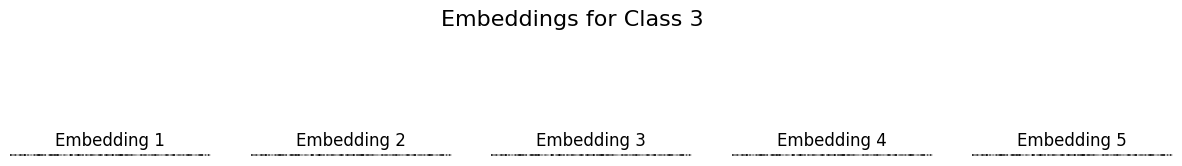

In [22]:
# Assuming class_embeddings is a dictionary containing embeddings grouped by class
class_label = 3  # Class label for which you want to examine embeddings

# Get embeddings for class 3
embeddings_class_3 = class_embeddings[class_label]

# Plot a few embeddings from class 3
num_embeddings_to_plot = min(5, len(embeddings_class_3))  # Plot at most 5 embeddings
plt.figure(figsize=(15, 3))
for i in range(num_embeddings_to_plot):
    plt.subplot(1, num_embeddings_to_plot, i + 1)
    plt.imshow(embeddings_class_3[i], cmap='gray')
    plt.title(f'Embedding {i+1}')
    plt.axis('off')
plt.suptitle('Embeddings for Class 3', fontsize=16)
plt.show()